In [1]:
%matplotlib inline

In [2]:
#parallel
from ipyparallel import Client
rc = Client(profile="default")
dview = rc[:] # use all engines
lv = rc.load_balanced_view()

In [3]:
%%px --local
import os
import numpy as np
import pandas as pd
import vcf, pyfasta
chromosomes = ["CAE" + str(i) for i in range(1,30) + ["X"] + ['Y'] ]
eu = os.path.expanduser
jn = os.path.join
var_ana_dir = eu("~/vervet_project/analyses/20140403_UnifiedGenotyper_ref3500_non_VRC/_data")
meta_dir = eu("~/vervet_project/metadata")
gene_df_ensembl = pd.read_csv(jn(meta_dir,"annot_ensemble_1.1.77_genes.tsv"),sep="\t",index_col=[0,1])
gene_df_ensembl_CDS = pd.read_csv(jn(meta_dir,"annot_ensemble_1.1.77_CDS.tsv"),sep="\t",index_col=[0,1])
mac_seq = pyfasta.Fasta(eu("~/vervet_project/data/other_species/Macaca_mulatta/CR_1.0_in_vervet_coord_ref3500.fa"))

In [4]:
gene_df_ensembl['gene_name'].to_csv(jn(meta_dir,'annot_ensemble_1.1.77_gene_names.txt'),index=False)

## Approach extracting vervet SNPs and macaque differences (specially prepared VCF that includes differences)

In [517]:
%%px --local
def get_gen_df(chrom):
    """
    get 0,1,2 genotype data frame
    """
    fn = jn(var_ana_dir,"UGr_163_ref3500_ref_alt_{}_2.012".format(chrom))
    df = pd.read_csv(fn,index_col=[0,1],sep="\t",na_values="N")
    return df.astype(np.float16)



def coding_variants_per_gene(gen_df,gene_df):
    """
    Get the variants in gen_df which lie within a feature
    (e.g. gene) in gene_df.
    Input:
    gen_df... rod such as SNP genotypes
    gene_df... index must be (chrom,feature_name), must have columns 'start', 'end'
    """
    gene_hit_df = pd.DataFrame()
    for chrom in gen_df.index.droplevel(1).unique():
        pos_rel_to_start = gene_df.ix[chrom]['start'].searchsorted(gen_df.ix[chrom].index)
        pos_rel_to_end = np.searchsorted(gene_df.ix[chrom]["end"].values,gen_df.ix[chrom].index.values)
        in_gene = (pos_rel_to_start - pos_rel_to_end) == 1
        gene_id = gene_df.ix[chrom].iloc[pos_rel_to_end[in_gene]].index
        snp_df = gen_df.ix[chrom][in_gene]
        snp_df['chrom'] = chrom
        snp_df['gene_id'] = gene_id
        snp_df.set_index(['chrom','gene_id'],append=True,inplace=True)
        snp_df = snp_df.reorder_levels(['chrom', 'gene_id','pos'])
        gene_hit_df = gene_hit_df.append(snp_df)
    return gene_hit_df

def add_effect(eff_dic,effect):
    try:
        eff_dic[effect] += 1
    except KeyError:
        eff_dic[effect] = 1

def get_snp_annotation(gene_id, gene_df, snp_df, outgroup_fasta, vcfr):
    """
        missing alignments must be coded as 'N' in outgroup_fasta
    """
    prev_pos = ["CAE0",0]
    bases = ['A','C','G','T']
    no_var = ['.','X',None]
    try:
        snp_index = snp_df.xs(gene_id,level=1,drop_level=False).index
    except KeyError:
        snp_index = []
    
    exon_df = gene_df.xs(gene_id,level=1,drop_level=False)
    snp_eff_df = pd.DataFrame(columns=['ref','alt','AA','impact','effect'],
                              index=snp_index)
    #snp_df = snp_df.xs(gene_id,level=1)
    coding_sites = 0
    coding_outgroup_align = 0 
    outgroup_effect = {}#{'syn':0,'ns':0}
    outgroup_impact = {}#{'syn':0,'ns':0}
    filter_stats = {'filter_snp':0,'filter_no_snp':0}
    
    for exon in exon_df.itertuples():
        (chrom, id), start, end, name, type0 = exon
        #print chrom, id, start, end, name, type0
        outgroup_str = outgroup_fasta[start-1:end-1].upper()
        coding_outgroup_align += len(outgroup_str) - outgroup_str.count('N')
        ex_vcf = vcfr.fetch(chrom,start,end)
        for record in ex_vcf:
            if prev_pos == [record.CHROM,record.POS]: #skip multiple entries
                continue
            coding_sites += 1
            if len(record.ALT) == 1 and record.ALT[0] in bases: #check whether SNP (in vervet) or diff to macaque
                #add_effect(var_dic,record.INFO["ANN"][0].split('|')[1])
                ann = record.INFO['ANN']
                #if len(ann)!=1:
                #    print record.ALT
                #    print ann
                #wont work there are biallelic SNPs (filtered)
                ann_ls = ann[0].split('|')
                #'ANN': ['|intergenic_region|MODIFIER|ENSCSAG00000018297|ENSCSAG00000018297|intergenic_region|ENSCSAG00000018297|||n.||||||']
                try: #snp in vervet?
                    af = record.INFO["AF"][0]
                    #print "SNP"
                    if af>0 and af<1:
                        #print "seg. SNP"
                        #print record.FILTER, record.INFO
                        if  not record.FILTER:
                            snp_eff_df.ix[(chrom,id,record.POS),"ref"] = record.REF
                            snp_eff_df.ix[(chrom,id,record.POS),"alt"] = record.ALT[0]
                            assert record.ALT[0] == ann_ls[0]
                            snp_eff_df.ix[(chrom,id,record.POS),"AA"] = outgroup_fasta[record.POS]
                            snp_eff_df.ix[(chrom,id,record.POS),"impact"] = ann_ls[2]
                            snp_eff_df.ix[(chrom,id,record.POS),"effect"] = ann_ls[1].split('&')[0]
                            #raise
                        else:
                            filter_stats['filter_snp'] +=1
                            #add to filtered variants
                except KeyError:
                    #difference to macaque
                    if not record.FILTER or (len(record.FILTER)==1 and record.FILTER[0]=='LowQual'):
                        #unfiltered diff
                        add_effect(outgroup_effect, ann_ls[1].split('&')[0]) 
                        add_effect(outgroup_impact,ann_ls[2]) 
                    else:
                        filter_stats['filter_no_snp'] +=1
        #elif: #alternatively one could check for indels (disable skip above)
        #or multiallelic variants

            elif not record.FILTER or (len(record.FILTER)==1 and record.FILTER[0]=='LowQual'):
                #print "non filtered non-snp"
                pass
            else:
                filter_stats['filter_no_snp'] += 1
            
            #add_effect(novar_dic,record.INFO["ANN"][0].split('|')[1])    
                
                
                
            #break
            prev_pos = [record.CHROM,record.POS]
    try:
        fraction_outgroup_align = coding_outgroup_align*1./coding_sites
    except ZeroDivisionError:
        fraction_outgroup_align = 0
    #if len(snp_eff_df) + 
    stats_dic = {'coding_sites':coding_sites, 'fraction_outgroup_align':fraction_outgroup_align}
    stats_dic.update({"outgroup_"+k:v for k,v in outgroup_effect.iteritems()})
    stats_dic.update({"outgroup_"+k:v for k,v in outgroup_impact.iteritems()})
    stats_dic.update(filter_stats)
    stats = pd.Series(stats_dic)
    stats.name = id
    return snp_eff_df, stats

def reduce_effect_annot(results):
    snp_eff_df = pd.concat([r[0] for r in results])
    stats_df = pd.DataFrame([r[1] for r in results])
    return snp_eff_df, stats_df

def get_effects_chrom(chrom):
    vcfr = vcf.Reader(filename=jn(var_ana_dir,
                              "GATK_UnifiedGenotyper_163NonVRC_ref3500_all_sites_{}_"
                              "mac_diff_as_snps.snpeff_ensembl_1.1.78.vcf.gz".format(chrom)))
    gen_df = get_gen_df(chrom)
    coding_snp_df = coding_variants_per_gene(gen_df,gene_df_ensembl_CDS)
    result = map(lambda id: get_snp_annotation(id, gene_df_ensembl_CDS, coding_snp_df , mac_seq[chrom], vcfr),gene_df_ensembl_CDS.ix[chrom].index.values)
    snp_eff_df, stats_df = reduce_effect_annot(result)
    snp_eff_df.to_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format(chrom)),sep='\t')
    stats_df.to_csv(jn(var_ana_dir,"snp_eff_stats_df_{}.tsv".format(chrom)),sep='\t')
    
def test(x):
    return x

In [1]:
"".split(',')

['']

In [368]:
map_effects = lv.map_async(get_effects_chrom,chromosomes[:-1])

In [371]:
map_effects.wait(10)

In [ ]:
#fix problem for CAE5
from ast import literal_eval
snp_eff_df = pd.read_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format('CAE5')),sep='\t')
snp_eff_df.index = pd.MultiIndex.from_tuples(snp_eff_df['Unnamed: 0'].apply(literal_eval))
snp_eff_df.index.names = ['chrom','gene_id','pos']
del snp_eff_df['Unnamed: 0']
snp_eff_df.to_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format('CAE5')),sep='\t')

In [197]:
coding_snp_df = coding_variants_per_gene(gen_df,gene_df_ensembl_CDS)

In [422]:
rc[0].execute('get_effects_chrom("CAE8")')

<AsyncResult: execute>

In [331]:
snp_eff_df, stats_df = reduce_effect_annot(result)

## High impact mutations between macaque and vervet

Starting from the information exracted above

In [518]:
%%px --local
assoc_dir = eu("~/vervet_project/data/gene_associations")
gene_to_name = pd.read_csv(jn(assoc_dir,"gene_to_name.csv"),index_col=0)
gene_to_name.drop_duplicates('gene_symbol',inplace=True)

In [535]:
gene_to_cat = pd.read_csv(jn(assoc_dir,"gene_to_cat.csv"),index_col=0)

In [519]:
%%px --local
def get_broken_genes(chrom):
    #snp_eff_df = pd.read_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format(chrom)),sep='\t',index_col=[0,1])
    stats_df = pd.read_csv(jn(var_ana_dir,"snp_eff_stats_df_{}.tsv".format(chrom)),sep='\t',index_col=[0])
    stats_df = stats_df.reset_index().drop_duplicates().set_index("index")
    stats_df.index.name = "gene_id"
    broken_genes = pd.DataFrame(stats_df[stats_df['outgroup_HIGH']>0]['fraction_outgroup_align'],columns=['fraction_outgroup_align'])
    broken_genes = broken_genes.join(gene_df_ensembl.reset_index().set_index("gene_id"))
    broken_genes['gene_description'] = gene_to_name.set_index("gene_symbol").ix[broken_genes['gene_name']].values
    return broken_genes

In [520]:
map_broken = lv.map_async(get_broken_genes,chromosomes[:-1])

In [521]:
map_broken.wait(10)

In [525]:
broken_genes = pd.concat(map_broken.result,axis=0)

In [529]:
broken_genes[broken_genes['fraction_outgroup_align']>0.8].gene_name.to_csv(jn(meta_dir,"genes_broken_rel_to_macaque_alignGT80pct.txt"),index=False)

In [555]:
broken0p8 = broken_genes[broken_genes['fraction_outgroup_align']>0.8]

In [583]:
ngenes = len(broken0p8)

In [565]:
def get_go_assoc(gene_ls, gene_to_go):
    """
    Get series with number of genes associated with each
    category in gene_to_go
    """
    s = gene_to_go.set_index("gene_symbol").ix[gene_ls].dropna().groupby("go_identifier").apply(len)
    return s

In [603]:
def random_gene_assoc_table(n_permut,n_genes,gene_df,gene_to_go):
    assoc_table = pd.DataFrame()
    for i in xrange(n_permut):
        genes = np.random.choice(gene_df_ensembl["gene_name"].unique(),n_genes)
        assoc = get_go_assoc(genes, gene_to_go)
        assoc.name = i
        assoc_table = assoc_table.join(assoc,how='outer')
    return assoc_table

def get_rank(series,rank_df):
    go = series.name
    try:
        go_s = rank_df.ix[go]
    except KeyError:
        go_s = pd.Series({"n_genes":0,"rank":0,"out_of":0})
    real_val = go_s["n_genes"]
    old_rank = go_s["rank"]
    old_out_of = go_s["out_of"]
    rank = empirical_rank(real_val,series.values)
    new_rank = old_rank + rank
    new_out_of = old_out_of + len(series)
    return pd.Series({"n_genes":real_val,"rank":new_rank,"out_of":new_out_of})

def get_initial_rank_table(real_assoc):
    return pd.DataFrame({"n_genes":real_assoc.values,"rank":0,"out_of":0},index=real_assoc.index)

def update_rank(rank_table,assoc_table):
    r = assoc_table.apply(lambda row: get_rank(row,rank_table),axis=1)
    return r

def empirical_rank(value,dist):
    """
    get empirical p value of
    value with respect to list of 
    values in dist
    """
    array = np.append(value,dist)
    temp = array.argsort()
    ranks = np.empty(len(array), int)
    ranks[temp] = np.arange(len(array))
    return ranks[0]

def get_p_val(rank_table):
    """
    Input:
    
    """
    r =  1-rank_table["rank"]*1./(rank_table["out_of"]+1)
    r.sort()
    return r

In [608]:
rand_assoc_table = random_gene_assoc_table(1000,ngenes,gene_df_ensembl,gene_to_cat)

In [601]:
real_assoc = get_go_assoc(broken0p8['gene_name'].values, gene_to_cat)

In [605]:
init_rank = get_initial_rank_table(real_assoc)

In [609]:
rank_table = update_rank(init_rank,rand_assoc_table)

In [610]:
rank_table.sort('rank',ascending=False)

,n_genes,out_of,rank
go_identifier,,,
GO:0005576,45,1000,997
GO:0003676,32,1000,993
GO:0019221,11,1000,987
GO:0005929,8,1000,960
GO:0007411,11,1000,945
GO:0005759,8,1000,943
GO:0050911,7,1000,940
GO:0004984,7,1000,940
GO:0007608,7,1000,927


<font size="5"><font color="red">CONCLUSION:</font> Nothing significant</font>

## dn ds pn ps per gene vervet vs macaque

In [ ]:
attention, gereally speaking pn ps is not polymporphism since it includes fixed differences across vervet subspecies!!!

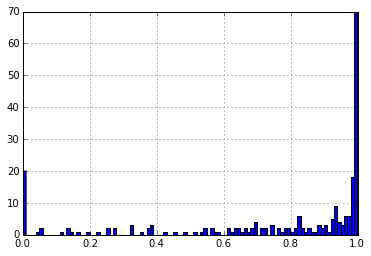

In [446]:
stats_df["fraction_outgroup_align"].hist(bins=100)

In [611]:
chrom = 'CAE28'

In [612]:
snp_eff_df = pd.read_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format(chrom)),sep='\t',index_col=[0,1])
stats_df = pd.read_csv(jn(var_ana_dir,"snp_eff_stats_df_{}.tsv".format(chrom)),sep='\t',index_col=[0])

In [646]:
%%px --local
def get_pn_ps(one_gene_df):
    return pd.Series({"ps":(one_gene_df['effect']=='synonymous_variant').sum(),\
                'pn':(one_gene_df['effect']=='missense_variant').sum()})

def get_dn_ds_pn_ps(chrom):
    snp_eff_df = pd.read_csv(jn(var_ana_dir,"snp_eff_df_{}.tsv".format(chrom)),sep='\t',index_col=[0,1])
    stats_df = pd.read_csv(jn(var_ana_dir,"snp_eff_stats_df_{}.tsv".format(chrom)),sep='\t',index_col=[0])
    stats_df = stats_df.reset_index().drop_duplicates().set_index("index")
    stats_df.index.name = "gene_id"
    try:
        df = snp_eff_df.reset_index().groupby("gene_id").apply(get_pn_ps)
    except:
        return chrom
    df['dn'] = stats_df['outgroup_missense_variant']
    df['ds'] = stats_df['outgroup_synonymous_variant']
    df['fraction_outgroup_align'] = stats_df['fraction_outgroup_align']
    return df.fillna(0)

In [666]:
mk_map = lv.map_async(get_dn_ds_pn_ps,chromosomes[:-1])

In [697]:
dn_ds_pn_ps_df = pd.concat(mk_map.result)

In [669]:
total = dn_ds_pn_ps_df[dn_ds_pn_ps_df['fraction_outgroup_align']>0.8].sum(axis=0)
neutrality_index = (total['pn']*1./total['ps'])/(total['dn']/total['ds'])
alpha = 1 - neutrality_index

In [671]:
neutrality_index

1.0879167150736777

In [672]:
alpha

-0.087916715073677709

### per gene category

In [712]:
go_to_name = pd.read_csv(jn(assoc_dir,"cat_to_name.csv"),index_col=0)

In [698]:
mk_df = dn_ds_pn_ps_df[dn_ds_pn_ps_df['fraction_outgroup_align']>0.8]
mk_df['gene_name'] = gene_df_ensembl.set_index('gene_id').ix[mk_df.index]['gene_name']
mk_per_go = mk_df.set_index('gene_name').ix[gene_to_cat['gene_symbol']]
mk_per_go['go_identifier'] = gene_to_cat.set_index('gene_symbol')
mk_per_go = mk_per_go.groupby('go_identifier').sum()

In [699]:
mk_per_go['neutrality_index'] = (mk_per_go['pn']*1./mk_per_go['ps'])/(mk_per_go['dn']/mk_per_go['ds'])

In [700]:
mk_per_go['alpha'] = 1 - mk_per_go['neutrality_index']

In [714]:
nonzero_mk_per_go = mk_per_go[(mk_per_go[['pn','ps','dn','ds']]>0).all(axis=1)].sort('alpha')

In [716]:
nonzero_mk_per_go['go_name'] = go_to_name.set_index('go_identifier').drop_duplicates().ix[nonzero_mk_per_go.index]

In [721]:
nonzero_mk_per_go

,pn,ps,dn,ds,fraction_outgroup_align,neutrality_index,alpha,go_name
go_identifier,,,,,,,,
GO:0008310,106,3,10,13,1.871988,45.933333,-44.933333,single-stranded DNA 3'-5' exodeoxyribonuclease...
GO:2000110,66,6,1,3,1.921671,33.000000,-32.000000,negative regulation of macrophage apoptotic pr...
GO:0031861,12,2,1,4,0.969349,24.000000,-23.000000,prolactin-releasing peptide receptor binding
GO:0048483,12,2,1,4,0.969349,24.000000,-23.000000,autonomic nervous system development
GO:0006610,85,34,1,7,0.989349,17.500000,-16.500000,ribosomal protein import into nucleus
GO:0000340,66,12,1,3,1.987008,16.500000,-15.500000,RNA 7-methylguanosine cap binding
GO:0032020,70,28,1,6,2.911452,15.000000,-14.000000,ISG15-protein conjugation
GO:0042296,66,22,1,5,1.915492,15.000000,-14.000000,ISG15 ligase activity
GO:0003335,35,7,1,3,0.954600,15.000000,-14.000000,corneocyte development


In [720]:
nonzero_mk_per_go.ix['hiv155871.0']

pn                                                                    114210
ps                                                                    278844
dn                                                                      2460
ds                                                                      6155
fraction_outgroup_align                                             791.4731
neutrality_index                                                    1.024792
alpha                                                            -0.02479212
go_name                    interaction with hiv protein Tat from http://w...
Name: hiv155871.0, dtype: object

In [ ]:
calculate divergence across vervet vs divergence to macaque -> accellerated gene evolution

### pn ps for specific snps

## Approach parsing the whole gene sequence in vcf:

In [ ]:
Requirements:
80% of exon non-filtered

Check:
percentage of exon non-filtered
alignment of exon to macaque


In [ ]:
def get_gene_effect(gene_vcf):
    for record in gene_vcf:
        

In [106]:
"""
Notes: 
We are ignoring indels for now.
We are ignoring complicated effects,
only count syn/ nonsyn and impact of the others 
We do not look at effects of filtered sites.

This is only to extract overall effects. We need to look deeper for other effects

"""
gene_info_df = pd.DataFrame()
prev_pos = ["CAE0",0]
bases = ['A','C','G','T']
no_var = ['.','X',None]
variant_types_per_gene = {}

var_dic = {}

novar_dic = {}

for gene in gene_df_ensembl.ix[chrom].iloc[19:27].itertuples():
    start, end, id, name, type0 = gene
    g_mac_seq = mac_seq['{}'.format(chrom)][start:end]
    g_vcfr = vcfr.fetch(chrom,start,end)
    variant_types_per_gene.update({name:[]})
    dn = 0
    ds = 0
    pn = 0
    ps = 0
    d_impacts = {}
    p_impacts = {}
    exon_sites = 0
    exon_sites_non_filter = 0
    exon_sites_non_filter_macaque_info = 0
    
    #types = 
    for i,record in enumerate(g_vcfr):
        if prev_pos == [record.CHROM,record.POS]: #skip multiple entries
            continue
        if len(record.ALT) == 1 and record.ALT[0] in bases: #check whether SNP (in vervet) or diff to macaque
            add_effect(var_dic,record.INFO["ANN"][0].split('|')[1])
            try: #snp in vervet?
                af = record.INFO["AF"][0]
                #print "SNP"
                if af>0 and af<1:
                    #print "seg. SNP"
                    #print record.FILTER, record.INFO
                    if  not record.FILTER:
                        print "pass SNP"
                        raise
                    else:
                        pass
                        #add to filtered variants
            except KeyError:
                pass
        #elif: #alternatively one could check for indels (disable skip above)
        #or multiallelic variants

        else:
            add_effect(novar_dic,record.INFO["ANN"][0].split('|')[1])
        #check whether filtered
        #if 
        #check whether exon
        
        #check whether different in 
        #snpeff_fields = record.INFO['ANN'][0].split('|')
        #variant_types_per_gene[name].append(snpeff_fields[0])
        #if len(record.INFO['ANN'])>1:
        #    print "len>1"
        #    break
        #if i>50:
        #    break
        prev_pos = [record.CHROM,record.POS]
    s = pd.Series({"hallo":"du","we":np.random.rand()})  
    s.name = name
    gene_info_df = gene_info_df.append(s)

pass SNP


TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

In [95]:
var_dic

{'3_prime_UTR_variant': 45,
 'intron_variant': 20915,
 'missense_variant': 37,
 'splice_region_variant': 1,
 'splice_region_variant&intron_variant': 4,
 'stop_gained': 3,
 'synonymous_variant': 48}

In [96]:
novar_dic

{'3_prime_UTR_variant': 2405,
 '5_prime_UTR_variant': 120,
 'intragenic_variant': 342,
 'intron_variant': 457559,
 'missense_variant': 2,
 'non_coding_exon_variant': 4794,
 'splice_acceptor_variant&intron_variant': 60,
 'splice_donor_variant&intron_variant': 60,
 'splice_region_variant&intron_variant': 356,
 'splice_region_variant&non_coding_exon_variant': 198}

In [45]:
for k,v in variant_types_per_gene.iteritems():
    variant_types_per_gene[k] = list(set(v))

In [118]:
record.genotype["AA"]

TypeError: 'instancemethod' object has no attribute '__getitem__'

In [97]:
'3_prime_UTR_variant'.split("&")

['3_prime_UTR_variant']

In [46]:
variant_types_per_gene

{'COX7A2': ['splice_acceptor_variant&intron_variant',
  'splice_donor_variant&intron_variant',
  '3_prime_UTR_variant',
  'synonymous_variant',
  'splice_region_variant&intron_variant',
  'non_coding_exon_variant',
  'missense_variant',
  'splice_region_variant&non_coding_exon_variant',
  'intragenic_variant',
  'intron_variant'],
 'TMEM30A': ['splice_acceptor_variant&intron_variant',
  'disruptive_inframe_deletion',
  'splice_donor_variant&intron_variant',
  '3_prime_UTR_variant',
  'intragenic_variant',
  'synonymous_variant',
  'splice_region_variant&intron_variant',
  '5_prime_UTR_variant',
  'non_coding_exon_variant',
  'stop_retained_variant',
  'missense_variant',
  'splice_region_variant&non_coding_exon_variant',
  '5_prime_UTR_premature_start_codon_gain_variant',
  'intron_variant',
  'stop_gained',
  'inframe_insertion']}

In [117]:
record.samples

[Call(sample=A8518, CallData(GT=1/1, AB=None, AD=[0, 0], DP=3, GQ=9, PL=[85, 9, 0])),
 Call(sample=AG23, CallData(GT=1/1, AB=None, AD=[0, 7], DP=7, GQ=15, PL=[175, 15, 0])),
 Call(sample=AG5417, CallData(GT=1/1, AB=None, AD=[0, 15], DP=15, GQ=45, PL=[439, 45, 0])),
 Call(sample=AGM126, CallData(GT=1/1, AB=None, AD=[0, 21], DP=2, GQ=6, PL=[9, 0, 0])),
 Call(sample=AGM127, CallData(GT=1/1, AB=None, AD=[0, 5], DP=5, GQ=12, PL=[133, 0, 0])),
 Call(sample=AGM129, CallData(GT=1/1, AB=None, AD=[0, 4], DP=4, GQ=9, PL=[106, 9, 102])),
 Call(sample=AGM130, CallData(GT=1/1, AB=None, AD=[0, 9], DP=9, GQ=15, PL=[208, 15, 0])),
 Call(sample=AGM131, CallData(GT=1/1, AB=None, AD=[0, 6], DP=6, GQ=15, PL=[7, 15, 0])),
 Call(sample=AGM136, CallData(GT=1/1, AB=None, AD=[0, 7], DP=7, GQ=21, PL=[2, 0, 0])),
 Call(sample=AGM137, CallData(GT=1/1, AB=None, AD=[0, 3], DP=3, GQ=9, PL=[8, 9, 0])),
 Call(sample=AGM141, CallData(GT=1/1, AB=None, AD=[0, 21], DP=21, GQ=63, PL=[629, 0, 0])),
 Call(sample=AGM142, CallD

In [122]:
[record.genotype(id)['GT'] for id in ['VGA00006']]

['0/1']

In [213]:
record.INFO

{'AN': 308,
 'ANN': ['|intergenic_region|MODIFIER|ENSCSAG00000018297|ENSCSAG00000018297|intergenic_region|ENSCSAG00000018297|||n.||||||'],
 'DP': 677,
 'MQ': 52.33,
 'MQ0': 12}

In [21]:
for i,record in enumerate(vcfr):
    print record
    if i>10:
        break

Record(CHROM=CAE6, POS=21, REF=C, ALT=[T])
Record(CHROM=CAE6, POS=67, REF=C, ALT=[T])
Record(CHROM=CAE6, POS=71, REF=A, ALT=[C])
Record(CHROM=CAE6, POS=73, REF=T, ALT=[C])
Record(CHROM=CAE6, POS=84, REF=T, ALT=[C])
Record(CHROM=CAE6, POS=85, REF=C, ALT=[T])
Record(CHROM=CAE6, POS=87, REF=A, ALT=[G])
Record(CHROM=CAE6, POS=93, REF=C, ALT=[T])
Record(CHROM=CAE6, POS=101, REF=G, ALT=[A])
Record(CHROM=CAE6, POS=103, REF=A, ALT=[T])
Record(CHROM=CAE6, POS=113, REF=A, ALT=[G])
Record(CHROM=CAE6, POS=119, REF=G, ALT=[A])


In [17]:
vcfr.metadata

OrderedDict()